In [1]:
# ONLY USE THIS BLOCK OF CODE ON NICASIA'S COMPUTER 
import sys
sys.path.append("/anaconda/lib/python2.7/site-packages")
#####


import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.preprocessing import PolynomialFeatures
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
import string
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
 = pd.read_csv("cleaned_data_imputed.csv")


## Data Cleaning

In [3]:
x_train = train.drop(['zestimate_amount'], 1)
y_train = train['zestimate_amount']
x_test = test.drop(['zestimate_amount'], 1)
y_test = test['zestimate_amount']

## Linear Regression 

In [4]:
# Fit plain regression on train set, evaluate on train and test sets
reg = Lin_Reg()
reg.fit(x_train.values, y_train.values)

train_r_squared_plain = reg.score(x_train, y_train)
test_r_squared_plain = reg.score(x_test, y_test)

print 'Plain Regression: R^2 score on training set', train_r_squared_plain
print 'Plain Regression: R^2 score on test set', test_r_squared_plain

Plain Regression: R^2 score on training set 0.229361079591
Plain Regression: R^2 score on test set 0.242281110478


## Ridge Regression 

We will implement Ridge Regression with cross validation and optimize our score with different regularization parameters.

In [5]:
#--------  k_fold_r_squared
# A function for k-fold cross validation with Ridge regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      num_folds (no. of folds for CV)
#      param_val (regularization parameter value)
# Return: 
#      average R^2 value across folds

def k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = Ridge_Reg(alpha = param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [6]:
# Store test & CV R^2 values for different regression parameter values
# Range: 10^-7, ... 10^7
max_pow_of_10 = 7
min_pow_of_10 = -7
num_params = max_pow_of_10 - min_pow_of_10 + 1

cv_r_squared = []
test_r_squared = []

# Iterate over various parameter values
for power_of_10 in range(min_pow_of_10, max_pow_of_10+1):
    
    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    # Fit regression model on train set, and evaluate test R^2
    reg = Ridge_Reg(alpha=10**power_of_10)
    reg.fit(x_train_std, y_train)
    test_r_squared.append(reg.score(x_test_std, y_test))
    
    # Evaluate 5-fold CV R^2
    cv_r_squared.append(k_fold_r_squared(x_train_std, y_train, 5, 10**power_of_10))

Ridge regression: Test R^2 score for CV choice 0.243537942
Ridge regression: Max Test R^2 score 0.250750672192
Plain regression: Test R^2 score: 0.242281110478


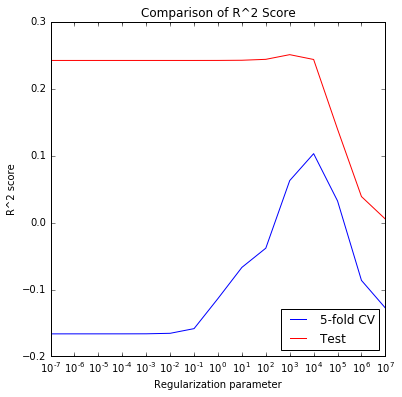

In [7]:
# Plot CV and test R^2 values as a function of parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            cv_r_squared, 
            c='b', 
            label='5-fold CV')
ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            test_r_squared, 
            c='r', 
            label='Test')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_title('Comparison of R^2 Score')
ax.legend(loc='lower right')

# Best CV parameter value
best_cv_param = np.argmax(cv_r_squared)

# Print R^2 for best CV parameter, max R^2 across all parameters, and R^2 for plain regression
print 'Ridge regression: Test R^2 score for CV choice', test_r_squared[best_cv_param]
print 'Ridge regression: Max Test R^2 score', max(test_r_squared)
print 'Plain regression: Test R^2 score:', test_r_squared_plain

plt.show()

## Lasso Regression

We will implement Lasso Regression with cross validation and optimize our score with different regularization parameters.

In [8]:
#--------  k_fold_r_squared
# A function for k-fold cross validation with Ridge regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      num_folds (no. of folds for CV)
#      param_val (regularization parameter value)
# Return: 
#      average R^2 value across folds

def k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = Lasso_Reg(alpha = param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [9]:
# Store test & CV R^2 values for different regression parameter values
# Range: 10^-7, ... 10^7
max_pow_of_10 = 7
min_pow_of_10 = -7
num_params = max_pow_of_10 - min_pow_of_10 + 1

cv_r_squared = []
test_r_squared = []

# Iterate over various parameter values
for power_of_10 in range(min_pow_of_10, max_pow_of_10+1):
    
    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    # Fit regression model on train set, and evaluate test R^2
    reg = Lasso_Reg(alpha=10**power_of_10)
    reg.fit(x_train_std, y_train)
    test_r_squared.append(reg.score(x_test_std, y_test))
    
    # Evaluate 5-fold CV R^2
    cv_r_squared.append(k_fold_r_squared(x_train_std, y_train, 5, 10**power_of_10))

/Users/meiyinwu/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Lasso regression: Test R^2 score for CV choice 0.24397195986
Lasso regression: Max Test R^2 score 0.24397195986
Plain regression: Test R^2 score: 0.242281110478


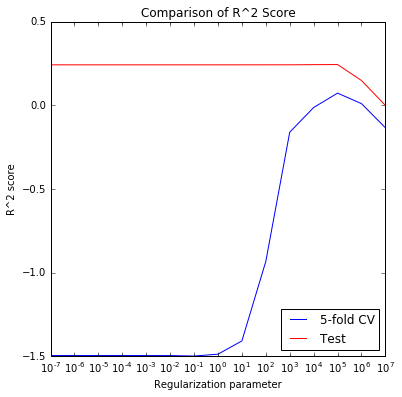

In [10]:
# Plot CV and test R^2 values as a function of parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            cv_r_squared, 
            c='b', 
            label='5-fold CV')
ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            test_r_squared, 
            c='r', 
            label='Test')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_title('Comparison of R^2 Score')
ax.legend(loc='lower right')

# Best CV parameter value
best_cv_param = np.argmax(cv_r_squared)

# Print R^2 for best CV parameter, max R^2 across all parameters, and R^2 for plain regression
print 'Lasso regression: Test R^2 score for CV choice', test_r_squared[best_cv_param]
print 'Lasso regression: Max Test R^2 score', max(test_r_squared)
print 'Plain regression: Test R^2 score:', test_r_squared_plain

plt.show()

## Polynomial Regression 

We will implement Polynomial Regression with cross validation. 

In [4]:
#--------  k_fold_r_squared
# A function for k-fold cross validation with Ridge regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      num_folds (no. of folds for CV)
#      param_val (regularization parameter value)
# Return: 
#      average R^2 value across folds

def k_fold_r_squared(x_train, y_train, num_folds):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', Lin_Reg(fit_intercept=False))])
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [ ]:
k_fold_r_squared(x_train, y_train, 5)

In [ ]:
reg = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', Lin_Reg(fit_intercept=False))])
reg.fit(x_train, y_train)
r_squared = reg.score(x_test, y_test)

# Best CV parameter value
best_cv_param = np.argmax(cv_r_squared)

# Print R^2 for best CV parameter, max R^2 across all parameters, and R^2 for plain regression
print 'Polynomial regression: Test R^2 score for CV choice', test_r_squared[best_cv_param]
print 'Polynomial regression: Max Test R^2 score', max(test_r_squared)
print 'Polynomial regression: Test R^2 score:', test_r_squared_plain